# Hybrid recommender
## Collaborative filtering + Content-Based

## Plan:
* Load and merge the wines metadata on WineID.
* Load the data, format columns to the correct types like:
    * Grapes and Harmonize (string list) -> (python list)  
    !!! This step is required in future always when loading this columns from csv.
    * Vintage (str) -> numeric. I just simply replace N.V.(non-vintage) with 0 and then turn whole column to integer type.
    * Datetime to a proper pd.datetime type
* Columns used:
    * **WineID**: Integer. The wine primary key identification;
    * **WineName**: String. The textual wine identification presented in the label;
    * **Type**: String. The categorical type classification: Red, white or rosé for still wines, gasified sparkling or dessert for sweeter and fortified wines. Dessert/Port is a subclassification for liqueur dessert wines;
    * **Elaborate**: String. Categorical classification between varietal or assemblage/blend. The most famous blends are also considered, such as * Bordeaux red and white blend, Valpolicella blend and Portuguese red and white blend;
    * **Grapes**: String list. It contains the grape varieties used in the wine elaboration. The original names found have been kept;
    * **Harmonize**: String list. It contains the main dishes set that pair with the wine item. These are provided by producers but openly recommended on the internet by sommeliers and even consumers;
    * **ABV**: Float. The alcohol by volume (ABV) percentage. According to [1], the value shown on the label may vary, and a tolerance of 0.5% per 100 volume is allowed, reaching 0.8% for some wines;
    * **Body**: String. The categorical body classification: Very light-bodied, light-bodied, medium-bodied, full-bodied or very full-bodied based on wine viscosity [37];
    * **Acidity**: String. The categorical acidity classification: Low, medium, or high, based on potential hydrogen (pH) score [38];
    * **Country**: String. The categorical origin country identification of the wine production (ISO-3166);
    * **RegionName**: String. The textual wine region identification. The appellation region name was retained when identified;
    * **WineryName**: String. The textual winery identification;
    * **UserID**: Integer. The sequential key without identifying the user's private data;
    * **Vintage**: String. A rated vintage year or the abbreviation "N.V." referring to "non-vintage";
    * **Date**: String. Datetime in the format YYYY-MM-DD hh:mm:ss informing when it was rated by the user. It can be easily converted to other formats.
    * **Rating**(**Target variable**): Float. It contains the 5-stars (1–5) rating value ⊂ {1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5} performed by the user;
* Columns dropped:
    * **RegionID** - since it is just unique IDs and not descriptive for the recommender.
    * **Code** - since it's the same meaning as **Country** column. Either one can be selected.
    * **Vintages** - since it's just lists of possible vintages and we already have a Vintage column with the exact value(year or 0 for non-vintage).

In [1]:

import pandas as pd
import ast
import numpy as np

# Training and evaluation
import optuna
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Preprocessing
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder, HashingEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix, issparse, lil_matrix, save_npz, load_npz


c:\Users\Denis\envs\webmining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Converter of string lists into Python lists
# (e.g. "['a', 'b', 'c']" → [a, b, c])
def parse_list_col(s):
    return ast.literal_eval(s)

# Converter of 'N.V.' to 0, so column is numeric
def parse_vintage(s):
    return 0 if s == 'N.V.' else int(s)

In [3]:
# Load the train and test splits
base_path = '..\..\data\main'

wines = pd.read_csv(
    f'{base_path}\\XWines_Full_100K_wines.csv', 
    usecols=['WineID', 'Type', 'Elaborate', 'ABV', 'Body', 'Acidity', 'RegionName', 'WineryName', 'Grapes','Harmonize','Country'],
    converters={
        'Grapes':    parse_list_col,
        'Harmonize': parse_list_col
    }
)
train = pd.read_csv(
    f'{base_path}\\trainset.csv', 
    usecols=['UserID', 'WineID', 'Rating', 'Date', 'Vintage'],
    parse_dates=['Date'],
    date_format=lambda s: pd.to_datetime(s),
    converters={'Vintage': parse_vintage}
)
test_uwarm_iwarm = pd.read_csv(
    f'{base_path}\\testset_warm_user_warm_item.csv', 
    usecols=['RatingID', 'UserID', 'WineID', 'Rating', 'Date', 'Vintage'],
    parse_dates=['Date'],
    date_format=lambda s: pd.to_datetime(s),
    converters={'Vintage': parse_vintage}
)
test_uwarm_icold = pd.read_csv(
    f'{base_path}\\testset_warm_user_cold_item.csv', 
    usecols=['RatingID', 'UserID', 'WineID', 'Rating', 'Date', 'Vintage'],
    parse_dates=['Date'],
    date_format=lambda s: pd.to_datetime(s),
    converters={'Vintage': parse_vintage}
)
test_ucold_iwarm = pd.read_csv(
    f'{base_path}\\testset_cold_user_warm_item.csv', 
    usecols=['RatingID', 'UserID', 'WineID', 'Rating', 'Date', 'Vintage'],
    parse_dates=['Date'],
    date_format=lambda s: pd.to_datetime(s),
    converters={'Vintage': parse_vintage}
)
test_ucold_icold = pd.read_csv(
    f'{base_path}\\testset_cold_user_cold_item.csv', 
    usecols=['RatingID', 'UserID', 'WineID', 'Rating', 'Date', 'Vintage'],
    parse_dates=['Date'],
    date_format=lambda s: pd.to_datetime(s),
    converters={'Vintage': parse_vintage}
)

In [4]:
# Merge ratings with wines metadata on 'WineID'
train = train.merge(wines, on='WineID', how='left')
test_uwarm_iwarm = test_uwarm_iwarm.merge(wines, on='WineID', how='left')
test_uwarm_icold = test_uwarm_icold.merge(wines, on='WineID', how='left')
test_ucold_iwarm = test_ucold_iwarm.merge(wines, on='WineID', how='left')
test_ucold_icold = test_ucold_icold.merge(wines, on='WineID', how='left')

# Check the shapes
print(f"Train shape: {train.shape}")
print(f"Test warm user warm item shape: {test_uwarm_iwarm.shape}")
print(f"Test warm user cold item shape: {test_uwarm_icold.shape}")
print(f"Test cold user warm item shape: {test_ucold_iwarm.shape}")
print(f"Test cold user cold item shape: {test_ucold_icold.shape}")

Train shape: (16917894, 15)
Test warm user warm item shape: (2036778, 16)
Test warm user cold item shape: (35456, 16)
Test cold user warm item shape: (506800, 16)
Test cold user cold item shape: (16504, 16)


## Preprocessing
### Preprocessing methods for different features:
* **Standard Scaler** - is used for numerical type columns
    * **ABV**
    * **Vintage** (formatted to be numerical)
    * **DaysAgo(Date)** - see below
* **One-hot-encoding** - is used for categorical features, but is limited by the number of categories within a feature:
    * **Type**
    * **Body**
    * **Acidity**
    * **Elaborate**
* **Multi-label Binarizer** - is used for categorical features with too many categories, where also multiple active categories could be possible:
    * **Grapes** (774 classes)
    * **Harmonize** (~64 classes)
* **Target Encoding** - used for text features and user IDs, wine IDs. Used with KFold(5 folds) to prevent data leakage, i.e. encoded feature never knows about it's own target value
* **Date encoding** - created custom object to convert datetime column to DaysAgo from the most recent record column. This way we keep information about time-related information and reduce feature to be simply numerical. **Standard Scaler** applied afterwards.

In [5]:
# Aggregate features

# Use StandardScaler for numerical features (create binary Is_NonVintage column derived from Vintage and maybe fill NaN values with 0)
numerical_features = ['ABV', 'Vintage']
# Use one-hot encoding for categorical features
categorical_features = ['Type', 'Elaborate', 'Body', 'Acidity']
# Use multilabel binarizer for multilabel features
tfidf_features = ['Grapes', 'Harmonize']
# Use target encoding for names and IDs
text_features = ['WineryName', 'RegionName', 'Country']
# Use hashing encoder for IDs
hashing_features = ['WineID', 'UserID']
# Use conversion to DaysAgo for time-based features
date_features = ['Date']

* **Create Preprocessing pipeline**:
    ##### **Important**: Since during Grapes column encoding we create 774 classes + there are around 100 classes from other encoders, the pandas DataFrame would require too much RAM (I recieved 69GB memory allocation error only for the Grapes column) and same happening for the dense array (numpy), I used csr_matrix from scipy.sparse and some additional optimizations for MultiLabelBinarizer in particular, to be able to store all the preprocessed features. More info in code below.

    * **Created custom object for Date column preprocessing**
    * **Created Wrappers for other preprocessors to always return sparse csr matricies**. For OneHotEncoding there is already implemented sparse output. For StandardScaler in date_pipeline wrapper is not required, since the input is already a csr matrix.
    * **Created pipelines for each preprocessor and a general pipeline to combine everything together, using ColumnTransformer** 

In [6]:
# Date preprocessor
class DateTransformer(BaseEstimator, TransformerMixin):
    """Transforms a single datetime column into 'days ago' relative to the latest date in training data."""
    
    def fit(self, X, y=None):
        # Expect a DataFrame with a single datetime column
        self.col = X.columns[0]
        self.column = f"{self.col}_days_ago"
        self.reference_date = pd.to_datetime(X[self.col]).max()
        return self

    def transform(self, X):
        days_ago = (self.reference_date - pd.to_datetime(X[self.col])).dt.days
        
        return csr_matrix(days_ago.values.reshape(-1, 1))

    def get_feature_names_out(self, input_features=None):
        return np.array([self.column])
    

class TFIDFWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidfs = {}
        self.feature_names = []
        

    def fit(self, X, y=None):
        for col in X.columns:
            tfidf = TfidfVectorizer()
            joined_col = X[col].apply(lambda x: ' '.join(x))
            tfidf.fit(joined_col)
            self.tfidfs[col] = tfidf
            self.feature_names.extend([f"{col}__{name}" for name in tfidf.get_feature_names_out()])
        return self

    def transform(self, X):
        matrices = []
        for col in X.columns:
            tfidf = self.tfidfs[col]
            joined_col = X[col].apply(lambda x: ' '.join(x))
            tfidf_matrix = tfidf.transform(joined_col)
            matrices.append(tfidf_matrix)
        return hstack(matrices, format='csr')

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)


class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.feature_names = []
    
    def fit(self, X, y):
        self.feature_names = []
        self.global_means = {}
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for col in X.columns:
            te = TargetEncoder(cols=[col])
            te.fit(X[[col]], y, cv=kf)
            self.encoders[col] = te
            self.global_means[col] = y.mean() 
            # Store feature names for this column
            self.feature_names.append(f'{col}_target_encoded')
        return self
    
    def transform(self, X):
        matricies = []
        for col in X.columns:
            te = self.encoders[col]
            df_encoded = te.transform(X[[col]])
            arr = df_encoded[col].fillna(self.global_means[col]).values.reshape(-1, 1)
            matricies.append(csr_matrix(arr))
        return hstack(matricies, format='csr')
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)
    
    
class FrequencyEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps = {}
        self.feature_names = []

    def fit(self, X, y=None):
        self.freq_maps = {}
        self.feature_names = [f"{col}_freq" for col in X.columns]
        for col in X.columns:
            self.freq_maps[col] = X[col].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        matrices = []
        for col in X.columns:
            freq = X[col].map(self.freq_maps[col]).fillna(0).values.reshape(-1, 1)
            matrices.append(csr_matrix(freq))
        return hstack(matrices, format='csr')

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)


class HashingEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = HashingEncoder(n_components=2**8)
        self.feature_names = []
    
    def fit(self, X, y=None):
        self.feature_names = []
        for col in X.columns:
            X[col] = X[col].astype(str)
        self.encoder.fit(X)
        # Store feature names for this column
        self.feature_names = [f"hash__{i}" for i in range(2**8)]
        return self
            
    def transform(self, X):
        for col in X.columns:
            X[col] = X[col].astype(str)
        df_encoded = self.encoder.transform(X)
        return csr_matrix(df_encoded.values)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)
    
class StandardScalerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler(with_mean=False)
        self.feature_names = []

    def fit(self, X, y=None):
        self.feature_names = X.columns.tolist()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        # Always return sparse csr_matrix
        if not issparse(X_scaled):
            X_scaled = csr_matrix(X_scaled)
        return X_scaled

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)

## Preprocessing pipeline

# Numerical
numerical_pipeline = Pipeline([
    ('scaler', StandardScalerWrapper()),
    ])

# Categorical via one-hot-encoding
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])


# Categorical via TFIDF
cattext_pipeline = Pipeline([
    ('tfidf', TFIDFWrapper())
])

# Names and IDs via target encoding
text_pipeline = Pipeline([
    ('target', TargetEncoderWrapper())
])

# HashingEncoder for IDs
hashing_pipeline = Pipeline([
    ('hashing', FrequencyEncoderWrapper())
])

# Datetime via custom date transformer
date_pipeline = Pipeline([
    ('date', DateTransformer()),
    ('scaler', StandardScaler(with_mean=False))
])

# Preprocessor
# Remainnder contains RatingID column, which is not needed for training neither for testing
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('cattext', cattext_pipeline, tfidf_features),
    ('target', text_pipeline, text_features),
    ('hashing', hashing_pipeline, hashing_features),
    ('date', date_pipeline, date_features)
], remainder='drop')

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])


* **Fit preprocessing pipeline on training data. We pass target variable there for the Target Encoder**
* **Transform train and test sets on a fitted preprocessor**

In [7]:
# Drop target column
X_train = train.drop(columns=['Rating'])
y_train = train['Rating']

X_test_uwarm_iwarm = test_uwarm_iwarm.drop(columns=['Rating'])
y_test_uwarm_iwarm = test_uwarm_iwarm['Rating']

X_test_uwarm_icold = test_uwarm_icold.drop(columns=['Rating'])
y_test_uwarm_icold = test_uwarm_icold['Rating']

X_test_ucold_iwarm = test_ucold_iwarm.drop(columns=['Rating'])
y_test_ucold_iwarm = test_ucold_iwarm['Rating']

X_test_ucold_icold = test_ucold_icold.drop(columns=['Rating'])
y_test_ucold_icold = test_ucold_icold['Rating']

In [8]:
# Fit the preprocessing pipeline
preprocessing_pipeline.fit(X_train, y_train)

X_train_transformed = preprocessing_pipeline.transform(X_train)
X_test_uwarm_iwarm_transformed = preprocessing_pipeline.transform(X_test_uwarm_iwarm)
X_test_uwarm_icold_transformed = preprocessing_pipeline.transform(X_test_uwarm_icold)
X_test_ucold_iwarm_transformed = preprocessing_pipeline.transform(X_test_ucold_iwarm)
X_test_ucold_icold_transformed = preprocessing_pipeline.transform(X_test_ucold_icold)

# Save feature names
feature_names = preprocessing_pipeline.get_feature_names_out()
# Check the size of feature names and transformed data
print(f"Feature names size: {len(feature_names)}")
print(f"Transformed train data size: {X_train_transformed.shape[1]}")

c:\Users\Denis\envs\webmining\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Denis\envs\webmining\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Denis\envs\webmining\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Denis\envs\webmining\Lib\site-packages\sklearn\pipeline.py:62: Futu

Feature names size: 971
Transformed train data size: 971


In [9]:
# Save transformed data to npz
save_npz(f'{base_path}\\preprocessed\\X_train_transformed.npz', X_train_transformed)
save_npz(f'{base_path}\\preprocessed\\X_test_uwarm_iwarm_transformed.npz', X_test_uwarm_iwarm_transformed)
save_npz(f'{base_path}\\preprocessed\\X_test_uwarm_icold_transformed.npz', X_test_uwarm_icold_transformed)
save_npz(f'{base_path}\\preprocessed\\X_test_ucold_iwarm_transformed.npz', X_test_ucold_iwarm_transformed)
save_npz(f'{base_path}\\preprocessed\\X_test_ucold_icold_transformed.npz', X_test_ucold_icold_transformed)

## LightGBM model run

In [10]:
# Train a LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_transformed, y_train, feature_name=list(feature_names))

y_pred_uwarm_iwarm = lgb_model.predict(X_test_uwarm_iwarm_transformed)
y_pred_uwarm_icold = lgb_model.predict(X_test_uwarm_icold_transformed)
y_pred_ucold_iwarm = lgb_model.predict(X_test_ucold_iwarm_transformed)
y_pred_ucold_icold = lgb_model.predict(X_test_ucold_icold_transformed)


# Save the predictions as RatingID, PredictedRating

# Warm user warm item
result_uwarm_iwarm = pd.DataFrame({
    'RatingID': test_uwarm_iwarm['RatingID'],
    'Rating': y_pred_uwarm_iwarm
})
result_uwarm_iwarm.to_csv(
    f'{base_path}\\lightgbm\\lightgbm_warm_user_warm_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Warm user cold item
result_uwarm_icold = pd.DataFrame({
    'RatingID': test_uwarm_icold['RatingID'],
    'Rating': y_pred_uwarm_icold
})
result_uwarm_icold.to_csv(
    f'{base_path}\\lightgbm\\lightgbm_warm_user_cold_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Cold user warm item
result_ucold_iwarm = pd.DataFrame({
    'RatingID': test_ucold_iwarm['RatingID'],
    'Rating': y_pred_ucold_iwarm
})
result_ucold_iwarm.to_csv(
    f'{base_path}\\lightgbm\\lightgbm_cold_user_warm_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Cold user cold item
result_ucold_icold = pd.DataFrame({
    'RatingID': test_ucold_icold['RatingID'],
    'Rating': y_pred_ucold_icold
})
result_ucold_icold.to_csv(
    f'{base_path}\\lightgbm\\lightgbm_cold_user_cold_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 14.106921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14464
[LightGBM] [Info] Number of data points in the train set: 16917894, number of used features: 814
[LightGBM] [Info] Start training from score 3.858911


c:\Users\Denis\envs\webmining\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [11]:
# Evaluate

# Calculate MSE for each test set
mse_uwarm_iwarm = mean_squared_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
mse_uwarm_icold = mean_squared_error(y_test_uwarm_icold, y_pred_uwarm_icold)
mse_ucold_iwarm = mean_squared_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
mse_ucold_icold = mean_squared_error(y_test_ucold_icold, y_pred_ucold_icold)

# Calculate RMSE for each test set
rmse_uwarm_iwarm = root_mean_squared_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
rmse_uwarm_icold = root_mean_squared_error(y_test_uwarm_icold, y_pred_uwarm_icold)
rmse_ucold_iwarm = root_mean_squared_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
rmse_ucold_icold = root_mean_squared_error(y_test_ucold_icold, y_pred_ucold_icold)

# Calculate MAE for each test set
mae_uwarm_iwarm = mean_absolute_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
mae_uwarm_icold = mean_absolute_error(y_test_uwarm_icold, y_pred_uwarm_icold)
mae_ucold_iwarm = mean_absolute_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
mae_ucold_icold = mean_absolute_error(y_test_ucold_icold, y_pred_ucold_icold)

# Print the results
print(f'MSE for warm user warm item: {mse_uwarm_iwarm:.4f}')
print(f'RMSE for warm user warm item: {rmse_uwarm_iwarm:.4f}')
print(f'MAE for warm user warm item: {mae_uwarm_iwarm:.4f}')
print('-' * 50)
print(f'MSE for warm user cold item: {mse_uwarm_icold:.4f}')
print(f'RMSE for warm user cold item: {rmse_uwarm_icold:.4f}')
print(f'MAE for warm user cold item: {mae_uwarm_icold:.4f}')
print('-' * 50)
print(f'MSE for cold user warm item: {mse_ucold_iwarm:.4f}')
print(f'RMSE for cold user warm item: {rmse_ucold_iwarm:.4f}')
print(f'MAE for cold user warm item: {mae_ucold_iwarm:.4f}')
print('-' * 50)
print(f'MSE for cold user cold item: {mse_ucold_icold:.4f}')
print(f'RMSE for cold user cold item: {rmse_ucold_icold:.4f}')
print(f'MAE for cold user cold item: {mae_ucold_icold:.4f}')


MSE for warm user warm item: 0.3768
RMSE for warm user warm item: 0.6139
MAE for warm user warm item: 0.4521
--------------------------------------------------
MSE for warm user cold item: 0.4543
RMSE for warm user cold item: 0.6740
MAE for warm user cold item: 0.5070
--------------------------------------------------
MSE for cold user warm item: 0.4780
RMSE for cold user warm item: 0.6913
MAE for cold user warm item: 0.5110
--------------------------------------------------
MSE for cold user cold item: 0.5877
RMSE for cold user cold item: 0.7666
MAE for cold user cold item: 0.5787


## XGBoost model run

In [12]:
# XGBoost with DMatrix
dtrain = xgb.DMatrix(X_train_transformed, label=y_train, feature_names=list(feature_names))
xgb_model = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    },
    dtrain=dtrain,
    num_boost_round=100
)

d_test_uwarm_iwarm = xgb.DMatrix(X_test_uwarm_iwarm_transformed, feature_names=list(feature_names))
d_test_uwarm_icold = xgb.DMatrix(X_test_uwarm_icold_transformed, feature_names=list(feature_names))
d_test_ucold_iwarm = xgb.DMatrix(X_test_ucold_iwarm_transformed, feature_names=list(feature_names))
d_test_ucold_icold = xgb.DMatrix(X_test_ucold_icold_transformed, feature_names=list(feature_names))

# Predict using the trained model
y_pred_uwarm_iwarm = xgb_model.predict(d_test_uwarm_iwarm)
y_pred_uwarm_icold = xgb_model.predict(d_test_uwarm_icold)
y_pred_ucold_iwarm = xgb_model.predict(d_test_ucold_iwarm)
y_pred_ucold_icold = xgb_model.predict(d_test_ucold_icold)

# Save the predictions as RatingID, PredictedRating
# Warm user warm item
result_uwarm_iwarm = pd.DataFrame({
    'RatingID': test_uwarm_iwarm['RatingID'],
    'Rating': y_pred_uwarm_iwarm
})
result_uwarm_iwarm.to_csv(
    f'{base_path}\\xgboost\\xgboost_warm_user_warm_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Warm user cold item
result_uwarm_icold = pd.DataFrame({
    'RatingID': test_uwarm_icold['RatingID'],
    'Rating': y_pred_uwarm_icold
})
result_uwarm_icold.to_csv(
    f'{base_path}\\xgboost\\xgboost_warm_user_cold_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Cold user warm item
result_ucold_iwarm = pd.DataFrame({
    'RatingID': test_ucold_iwarm['RatingID'],
    'Rating': y_pred_ucold_iwarm
})
result_ucold_iwarm.to_csv(
    f'{base_path}\\xgboost\\xgboost_cold_user_warm_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)
# Cold user cold item
result_ucold_icold = pd.DataFrame({
    'RatingID': test_ucold_icold['RatingID'],
    'Rating': y_pred_ucold_icold
})
result_ucold_icold.to_csv(
    f'{base_path}\\xgboost\\xgboost_cold_user_cold_item.csv', 
    index=False, 
    header=['RatingID', 'Rating']
)


In [13]:
# Evaluate
# Calculate MSE for each test set
mse_uwarm_iwarm = mean_squared_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
mse_uwarm_icold = mean_squared_error(y_test_uwarm_icold, y_pred_uwarm_icold)
mse_ucold_iwarm = mean_squared_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
mse_ucold_icold = mean_squared_error(y_test_ucold_icold, y_pred_ucold_icold)
# Calculate RMSE for each test set
rmse_uwarm_iwarm = root_mean_squared_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
rmse_uwarm_icold = root_mean_squared_error(y_test_uwarm_icold, y_pred_uwarm_icold)
rmse_ucold_iwarm = root_mean_squared_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
rmse_ucold_icold = root_mean_squared_error(y_test_ucold_icold, y_pred_ucold_icold)
# Calculate MAE for each test set
mae_uwarm_iwarm = mean_absolute_error(y_test_uwarm_iwarm, y_pred_uwarm_iwarm)
mae_uwarm_icold = mean_absolute_error(y_test_uwarm_icold, y_pred_uwarm_icold)
mae_ucold_iwarm = mean_absolute_error(y_test_ucold_iwarm, y_pred_ucold_iwarm)
mae_ucold_icold = mean_absolute_error(y_test_ucold_icold, y_pred_ucold_icold)
# Print the results
print(f'MSE for warm user warm item: {mse_uwarm_iwarm:.4f}')
print(f'RMSE for warm user warm item: {rmse_uwarm_iwarm:.4f}')
print(f'MAE for warm user warm item: {mae_uwarm_iwarm:.4f}')
print('-' * 50)
print(f'MSE for warm user cold item: {mse_uwarm_icold:.4f}')
print(f'RMSE for warm user cold item: {rmse_uwarm_icold:.4f}')
print(f'MAE for warm user cold item: {mae_uwarm_icold:.4f}')
print('-' * 50)
print(f'MSE for cold user warm item: {mse_ucold_iwarm:.4f}')
print(f'RMSE for cold user warm item: {rmse_ucold_iwarm:.4f}')
print(f'MAE for cold user warm item: {mae_ucold_iwarm:.4f}')
print('-' * 50)
print(f'MSE for cold user cold item: {mse_ucold_icold:.4f}')
print(f'RMSE for cold user cold item: {rmse_ucold_icold:.4f}')
print(f'MAE for cold user cold item: {mae_ucold_icold:.4f}')


MSE for warm user warm item: 0.3741
RMSE for warm user warm item: 0.6117
MAE for warm user warm item: 0.4501
--------------------------------------------------
MSE for warm user cold item: 0.4366
RMSE for warm user cold item: 0.6608
MAE for warm user cold item: 0.4883
--------------------------------------------------
MSE for cold user warm item: 0.4741
RMSE for cold user warm item: 0.6886
MAE for cold user warm item: 0.5099
--------------------------------------------------
MSE for cold user cold item: 0.5864
RMSE for cold user cold item: 0.7658
MAE for cold user cold item: 0.5727


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

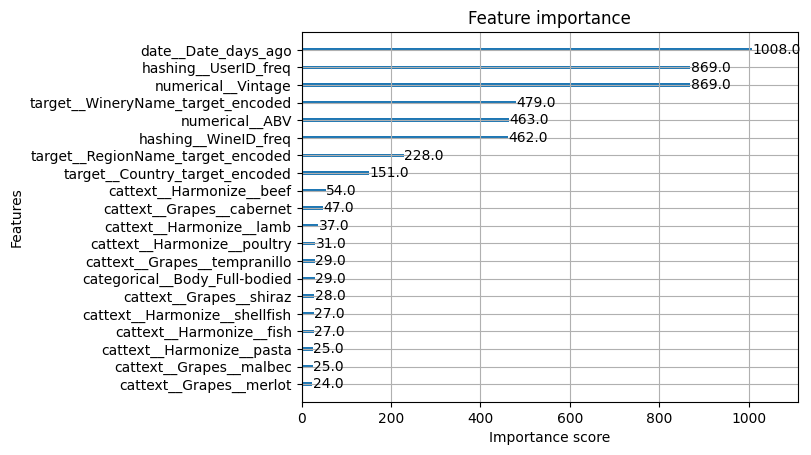

In [18]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=20)

#### TODO:
* Add other models (XGBoost|CatBoost, SVD|SVD++|NMF, MLP, KNN)
* Do Hyperparameter optimization

